In [1]:
import math
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from kan import KAN as PyKAN
from ptflops import get_model_complexity_info
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

plt.rcParams.update({'font.size': 18})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Torque target Stochastic Regression

In this notebook we're going to train a `PyKAN`, an `EfficientKAN`, and a `MLP` to learn a function that maps each set of input features to its own probability distribution.

We assume that the underlying process has many small, independent disturbances. Thus, Leveraging the Central limit theorem, we can say that the error between the model's prediction and **the actual observed value is likely to be normal**.

## Load dataset

In [40]:
USE_SYNTHETIC_DATASET = False  # Generated with 2-Synthetic_Dataset.ipynb

if USE_SYNTHETIC_DATASET:
    df = pd.read_csv('../dataset/3d_normal_std.csv')
    df_x = df.drop(columns=['id'])
    df_y = df['label']
else:
    original_df = pd.read_csv('../dataset/0-original/X.csv').drop(columns=['id'])
    preprocessed_df = pd.read_csv('../dataset/2-regression/X.csv')
    df_x = pd.concat([original_df, preprocessed_df], axis=1)
    df_y = pd.read_csv('../dataset/2-regression/y.csv')['trq_target']

dataset_x = torch.tensor(df_x.values, dtype=torch.float32, device=device)
dataset_y = torch.tensor(df_y.values, dtype=torch.float32, device=device).unsqueeze(1)
assert (dataset_x.shape[0] == dataset_y.shape[0])
preprocessed_df.head(50)

,mgt np ng,np ng^2,trq_measured,pa_air_density,np^2 ng,oat_air_density,ng_air_density
0,4.838370e+06,885390.597728,54.10000,1.566478e+00,792444.133936,0.014768,7.357562e-01
1,5.262927e+06,831415.685783,49.62500,8.575700e+02,905709.385014,12.777938,4.820896e+01
2,5.156455e+06,828530.481024,52.00000,4.191831e+02,912148.662816,1.533924,1.993225e+01
3,5.090961e+06,911482.946176,62.40000,8.043102e+00,823861.330688,0.210466,2.911113e+00
4,5.467208e+06,848766.312199,62.90000,3.778014e+00,920041.686577,1.637415,6.491207e+00
5,5.303830e+06,849990.684615,53.99805,9.619470e+02,918143.582302,8.371217,4.680290e+01
6,6.988622e+06,985284.333364,82.42969,1.062820e+03,986949.738570,14.770131,6.068913e+01
7,4.939393e+06,900898.425450,59.60000,-1.789463e+00,812836.618380,0.348020,3.024745e+00
8,5.949794e+06,899821.659967,67.61523,3.781928e+02,943674.643749,0.747012,1.678577e+01
9,6.339998e+06,960468.819382,81.90000,4.241559e+00,924995.594044,0.033219,1.206888e+00


In [34]:
# Split the dataset into train, valid, and test sets. Standardize the sets using only training means and stds.
def split_dataset(train_ratio=0.1, max=1) -> tuple[
    tuple[torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor]]:
    test_ratio = (max - train_ratio) / 2.0
    size = dataset_x.shape[0]
    random_indices = np.random.choice(size, size=size, replace=False)

    # Train set = 10% Data set
    train_x = dataset_x[random_indices[:int(size * train_ratio)]]
    train_y = dataset_y[random_indices[:int(size * train_ratio)]]
    train_x_mean = train_x.mean(dim=0)
    train_x_std = train_x.std(dim=0)
    train_y_mean = train_y.mean(dim=0)
    train_y_std = train_y.std(dim=0)
    train_x = (train_x - train_x_mean) / train_x_std
    train_y = (train_y - train_y_mean) / train_y_std

    # Valid set = 45% Data set
    valid_x = dataset_x[random_indices[int(size * train_ratio):int(size * (train_ratio + test_ratio))]]
    valid_y = dataset_y[random_indices[int(size * train_ratio):int(size * (train_ratio + test_ratio))]]
    valid_x = (valid_x - train_x_mean) / train_x_std
    valid_y = (valid_y - train_y_mean) / train_y_std

    # Test set = 45% Data set
    test_x = dataset_x[random_indices[int(size * (train_ratio + test_ratio)):int(size * 1)]]
    test_y = dataset_y[random_indices[int(size * (train_ratio + test_ratio)):int(size * 1)]]
    test_x = (test_x - train_x_mean) / train_x_std
    test_y = (test_y - train_y_mean) / train_y_std

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

## Define the train() and test() functions

In [10]:
def train(model, trainset, validset, optimizer, epochs, batch_size=8192):
    train_x, train_y = trainset
    valid_x, valid_y = validset
    criterion = nn.GaussianNLLLoss(reduction='mean')
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        epoch_train_losses = []
        epoch_validation_losses = []

        # Training
        model.train()
        with tqdm(range(train_x.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = train_x[i * batch_size:(i + 1) * batch_size]
                y = train_y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                mu, log_var = model(x)
                loss = criterion(mu, y.squeeze(), torch.exp(log_var))
                loss.backward()
                epoch_train_losses.append(loss.item())
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
        scheduler.step()

        # Validation
        model.eval()
        for i in range(valid_x.size(0) // batch_size):
            x = valid_x[i * batch_size:(i + 1) * batch_size]
            y = valid_y[i * batch_size:(i + 1) * batch_size]
            mu, log_var = model(x)
            loss = criterion(mu, y.squeeze(), torch.exp(log_var))
            loss.backward()
            epoch_validation_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))
        validation_losses.append(np.mean(epoch_validation_losses))

    # Plot losses
    plt.figure(figsize=(24, 8))
    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend()
    plt.show()

In [5]:
def test(model, testset) -> float:
    test_x, test_y = testset
    model.eval()
    criterion = nn.GaussianNLLLoss(reduction='mean')
    test_losses = []
    vars = []
    for i in range(test_x.size(0) // 8192):
        x = test_x[i * 8192:(i + 1) * 8192]
        y = test_y[i * 8192:(i + 1) * 8192]
        mu, log_var = model(x)
        loss = criterion(mu, y.squeeze(), torch.exp(log_var))
        vars.extend(torch.exp(log_var).detach().cpu().numpy().tolist())
        loss.backward()
        test_losses.append(loss.item())
    print(sum(vars) / len(vars))
    return sum(test_losses) / len(test_losses)

## Train the PyKAN

In [6]:
class Py_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Py_KAN, self).__init__()
        self.model = PyKAN(width=layers, grid=grid_size, k=3, device=device)

    def forward(self, x):
        x = self.model(x)
        mu = x[:, 0]
        var = x[:, 1]
        return mu, var

In [11]:
pyKAN = Py_KAN(layers=[[len(df_x.columns), 0], [1, 0], [2, 0]], grid_size=2)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
pyKAN.model = PyKAN.loadckpt('models/torque_target_stochastic_full_pykan.pt')

In [39]:
trainset[0].cpu()[:500]

tensor([[ 1.0627, -1.1991,  0.4380,  ..., -0.2717,  0.1713, -0.2422],
        [ 1.2888,  1.8992,  1.9199,  ...,  1.0920,  0.1713, -0.2422],
        [ 0.6481,  0.7219,  1.4788,  ...,  0.4212,  0.1713, -0.2422],
        ...,
        [ 1.1757, -0.0217,  0.6522,  ..., -0.0792,  0.1713, -0.2422],
        [ 1.0400, -1.1681,  0.3851,  ..., -0.3365,  0.1713, -0.2422],
        [-0.6256,  0.8458, -0.0232,  ...,  0.5503,  0.1713, -0.2422]])

In [35]:
trainset, validset, testset = split_dataset(train_ratio=0.6)
# train(pyKAN, trainset, validset, optim.Adam(pyKAN.parameters(), lr=0.05), epochs=80, batch_size=4096 * 2)

In [13]:
test(pyKAN, testset)

0.16250888000372596


-0.43105782402886283

In [116]:
pyKAN.model.saveckpt('models/torque_target_stochastic_full_pykan.pt')

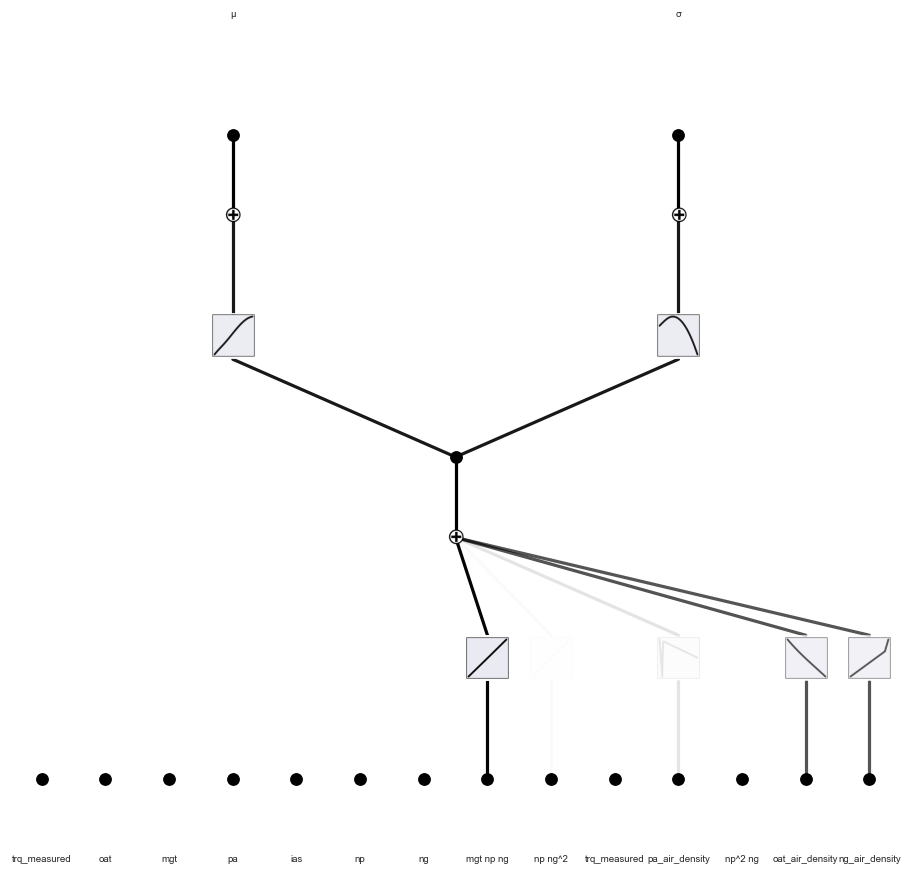

In [14]:
pyKAN.model.plot(scale=1.15, in_vars=df_x.columns.to_list(), out_vars=['μ', 'σ'], varscale=0.15)

keep: [False, False, False, False, False, False, False, True, False, False, False, False, True, True]
saving model version 1.3


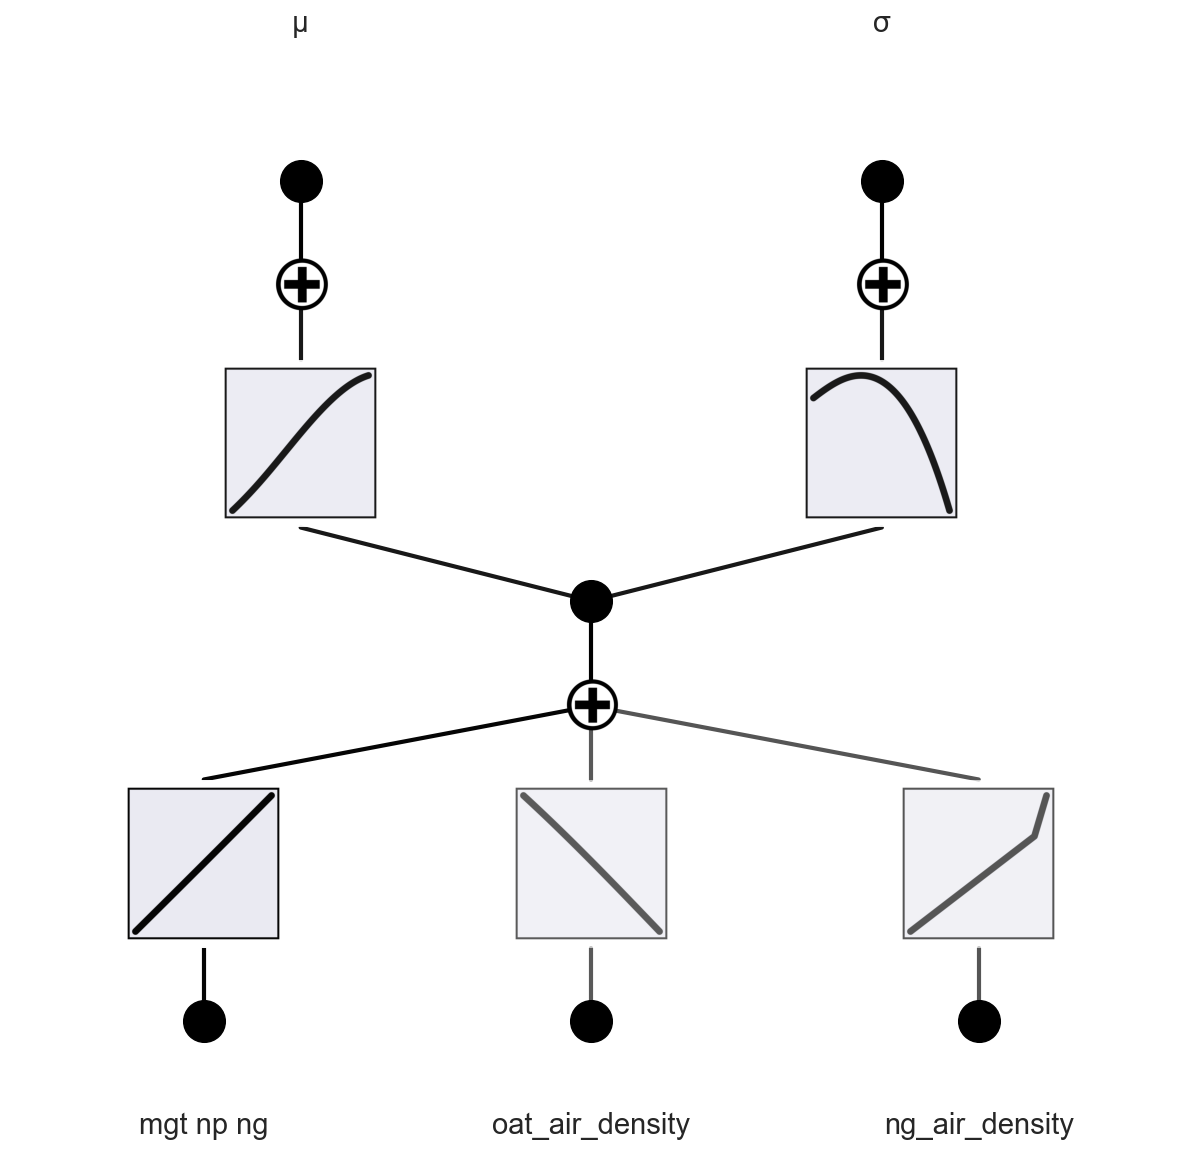

In [137]:
pyKAN.model.prune_input(0.05).plot(scale=1.5, in_vars=['mgt np ng', 'oat_air_density', 'ng_air_density'],
                                   out_vars=['μ', 'σ'], varscale=0.35)

## Train the EfficientKAN

In [ ]:
class Efficient_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Efficient_KAN, self).__init__()
        self.model = EffKAN(layers,
                            grid_size=grid_size,
                            # grid_eps=1,
                            # scale_base=0,
                            # sp_trainable=False,
                            # sb_trainable=False,
                            # enable_standalone_scale_spline=False
                            ).to(device)

    def forward(self, x):
        # x = x / dataset_size * 2 - 1
        # x = x.view(-1, self.layers[0])
        x = self.model(x)
        mu = x[:, 0]
        var = x[:, 1]  #F.softplus(x[:, 1]) + 1e-6
        return mu, var

In [ ]:
efficientKAN = Efficient_KAN(layers=[6, 1, 2], grid_size=2)

In [ ]:
efficientKAN.model.load_state_dict(torch.load('models/torque_target_stochastic_effkan.pt', weights_only=True))

In [ ]:
train(efficientKAN, optim.Adam(efficientKAN.parameters(), lr=0.02), epochs=150)

In [ ]:
test(efficientKAN)

In [ ]:
torch.save(efficientKAN.model.state_dict(), 'models/torque_target_stochastic_effkan.pt')

In [ ]:
def plot_spline(model: EffKAN, x_range, scale=1, resolution=50):
    base_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

    def random_color():
        return random.random(), random.random(), random.random()

    colors = [base_colors[x] if x < len(base_colors) else random_color()
              for x in range(max(map(lambda l: l.in_features, model.layers)))]
    for layer in reversed(model.layers):
        fig, axes = plt.subplots(1, layer.in_features * layer.out_features,
                                 figsize=(2 * scale * layer.in_features * layer.out_features, 2 * scale))
        for i in range(layer.in_features):
            for j in range(layer.out_features):
                x_vals = torch.linspace(x_range[0], x_range[1], resolution)

                # B-Splines
                if len(layer.grid) <= j:
                    continue
                grid = layer.grid[j, :].unsqueeze(0).to(device)  # The knots
                x = x_vals.unsqueeze(-1).unsqueeze(-1).to(device)
                bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)  # Determine the interval for each point
                for k in range(1, layer.spline_order + 1):
                    bases = (
                                    (x - grid[:, : -(k + 1)])
                                    / (grid[:, k:-1] - grid[:, : -(k + 1)])
                                    * bases[:, :, :-1]
                            ) + (
                                    (grid[:, k + 1:] - x)
                                    / (grid[:, k + 1:] - grid[:, 1:(-k)])
                                    * bases[:, :, 1:]
                            )

                y_vals = F.linear(bases.squeeze(), layer.scaled_spline_weight[j, i]).to(device)
                y_vals += (layer.base_activation(x_vals).to(device) * layer.base_weight[j, i].to(device))

                alpha = math.tanh(abs(3 * layer.spline_scaler.view(layer.out_features, -1)[j, i].item()))
                if type(axes) is np.ndarray:
                    axes[i * layer.out_features + j].plot(x_vals.cpu().detach().numpy(), y_vals.cpu().detach().numpy(),
                                                          alpha=alpha, color=colors[i])
                    axes[i * layer.out_features + j].grid(True)
                else:
                    axes.plot(x_vals, y_vals, alpha=alpha, color=colors[i])
                    axes.grid(True)

    # plt.tight_layout()
    plt.show()

In [ ]:
plot_spline(efficientKAN.model, [-3, 3], scale=1.75, resolution=100)

## Train the MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, layers_size, deterministic=False):
        super(MLP, self).__init__()
        self.layers_size = layers_size
        layers = []
        for i in range(len(layers_size) - 1):
            layers.append(nn.Linear(layers_size[i], layers_size[i + 1]))
            if i < len(layers_size) - 2:  # Add activation for all layers except the last one
                layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
        self.deterministic = deterministic

    def forward(self, x):
        output = self.model(x)
        if self.deterministic:
            return output
        else:
            mu = output[:, 0]
            var = output[:, 1]
            return mu, var

In [ ]:
mlp = MLP([6, 256, 256, 2], deterministic=False).to(device)

In [ ]:
mlp.load_state_dict(torch.load('models/torque_target_stochastic_mlp.pt', weights_only=True))

In [ ]:
train(mlp, optim.Adam(mlp.parameters(), lr=.01), epochs=300)

In [ ]:
torch.save(mlp.state_dict(), 'models/torque_target_stochastic_mlp.pt')

In [17]:
test(mlp)

1.2655238893217242e-05


-5.274217393663195

In [19]:
with torch.cuda.device(0):
    flops, params = get_model_complexity_info(mlp, (6,), as_strings=True)
    print(f"FLOPs: {flops}")
    print(f"Params: {params}")

MLP(
  68.1 k, 100.000% Params, 68.1 KMac, 100.000% MACs, 
  (model): Sequential(
    68.1 k, 100.000% Params, 68.1 KMac, 100.000% MACs, 
    (0): Linear(1.79 k, 2.632% Params, 1.79 KMac, 2.632% MACs, in_features=6, out_features=256, bias=True)
    (1): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (2): Linear(65.79 k, 96.614% Params, 65.79 KMac, 96.614% MACs, in_features=256, out_features=256, bias=True)
    (3): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (4): Linear(514, 0.755% Params, 514.0 Mac, 0.755% MACs, in_features=256, out_features=2, bias=True)
  )
)
FLOPs: 68.1 KMac
Params: 68.1 k


In [ ]:
def plot_mlp(net: MLP):
    layers = [net.model[0].in_features]
    linears = list(filter(lambda l: type(l) == torch.nn.modules.linear.Linear, mlp.model))
    for l in linears:
        layers.append(l.out_features)
    # layers = [6, 50, 50, 2]
    G = nx.Graph()
    pos = {}
    node_count = 0
    layer_gap = 5
    node_gap = 1
    max_layer = max(layers)

    for i, layer_size in enumerate(layers):
        delta = max_layer - layer_size
        for j in range(layer_size):
            G.add_node(node_count)
            pos[node_count] = (i * layer_gap, (j + delta // 2) * node_gap)
            if i > 0:
                for k in range(layers[i - 1]):
                    G.add_edge(node_count - layers[i - 1] + k - j, node_count,
                               weight=linears[i - 1].weight[j, k].item())
            node_count += 1

    weights = [G[u][v]['weight'] for u, v in G.edges()]
    plt.figure(1, figsize=(16, 4))
    plt.hist(weights, bins='auto', edgecolor='black')
    plt.grid()
    plt.title('Weights distribution')
    plt.figure(3, figsize=(85, 100))
    nx.draw(G, pos, with_labels=True, node_size=150, node_color="skyblue", edge_cmap=plt.colormaps['PiYG'],
            edge_color=weights, edge_vmin=-0.5, edge_vmax=0.5, font_size=10, width=5)
    plt.show()


plot_mlp(mlp)
